In [10]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

os.environ["NEURITE_BACKEND"] = "pytorch"

pd.set_option('display.max_colwidth', None)

In [11]:
datasets = ["ACDC", "PanDental", "SCD", \
            "STARE", "SpineWeb", "WBC", \
            "BTCV", "BUID", "HipXRay",\
            "TotalSegmentator", "COBRE", "SCR"]

In [12]:
from experiments.dataset.multisegment2d import MultiBinarySegment2D
dl = MultiBinarySegment2D(
    resolution=128, # options: 64, 128, 256
    allow_instance=False, # some datasets have instance labels, this merges them into semantic labels
    min_label_density=3e-3, # filters out examples where the label is empty
    preload=False,
    samples_per_epoch=1000,
    support_size=4,
    target_size=1,
    sampling='hierarchical',
    slicing=['midslice', 'maxslice'], # For 3D datasets, we extracted the midslices and the maxslices along each axis 
    split='train',
    context_split='train', 
    datasets=datasets, # if you set to None, it will use all available datasets but that takes a long time the first time you initialize it
)

In [13]:
import experiments.utils.paths
import neurite as ne

In [14]:
dl.init()

No updates to index
Filtered task_df: 1248
got task df: 1248


/data/ddmg/mvseg-ordering/experiments/dataset/multisegment2d.py:156: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["label_type"].fillna("soft", inplace=True)


target_datasets: 1248


In [15]:
dl.target_datasets

{624: BinarySegment2D(task='ACDC/Challenge2017/MRI/2', resolution=128, split='train', label=0, label_type='soft', slicing='maxslice', version='v4.2', min_label_density=0.003, background=False, allow_instance=False, preload=False, samples_per_epoch=None, generator=None, cutoff=None, seed=42),
 625: BinarySegment2D(task='ACDC/Challenge2017/MRI/2', resolution=128, split='train', label=1, label_type='soft', slicing='maxslice', version='v4.2', min_label_density=0.003, background=False, allow_instance=False, preload=False, samples_per_epoch=None, generator=None, cutoff=None, seed=42),
 626: BinarySegment2D(task='ACDC/Challenge2017/MRI/2', resolution=128, split='train', label=2, label_type='soft', slicing='maxslice', version='v4.2', min_label_density=0.003, background=False, allow_instance=False, preload=False, samples_per_epoch=None, generator=None, cutoff=None, seed=42),
 640: BinarySegment2D(task='BTCV/Cervix/CT/0', resolution=128, split='train', label=0, label_type='soft', slicing='maxsli

In [48]:
len(dl.target_datasets[964])

224

In [46]:
data = dl.target_datasets[964]
data

BinarySegment2D(task='TotalSegmentator/retrieved_2022-09-01/CT/0', resolution=128, split='train', label=100, label_type='soft', slicing='maxslice', version='v4.2', min_label_density=0.003, background=False, allow_instance=False, preload=False, samples_per_epoch=None, generator=None, cutoff=None, seed=42)

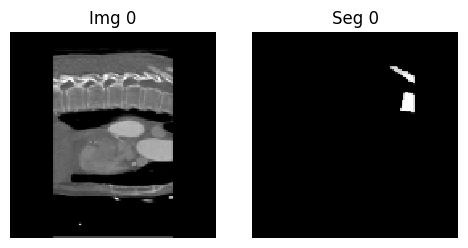

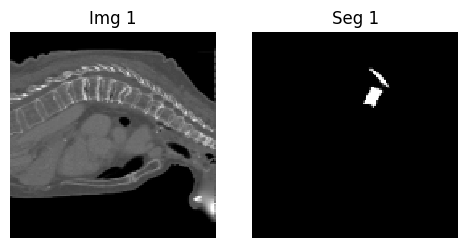

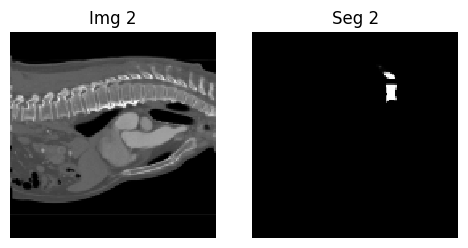

In [47]:
for i in range(3):
    img,seg = data[i]
    ne.plot.slices([img, seg], titles=[f'Img {i}', f'Seg {i}'], grid=(1,2), width=5)

In [ ]:
from pathlib import Path
import pandas as pd

# Point this to the Plan A folder for a run (either .../A or .../A/results)
exp_a_path = Path("experiments/scripts/experiment_4/commit_label_90/A")

# Resolve results directory whether user points to A or A/results
results_dir = exp_a_path if (exp_a_path / "support_images_summary.csv").exists() else (exp_a_path / "results")
summary_csv = results_dir / "support_images_summary.csv"
assert summary_csv.exists(), f"Missing {summary_csv}"

# Load per-image, per-permutation records
df = pd.read_csv(summary_csv)

# Sanity columns
required_cols = {"permutation_index", "image_index", "initial_dice"}
missing = required_cols - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

# Compute mean initial Dice per permutation
per_perm_mean = df.groupby("permutation_index")["initial_dice"].mean()

# Identify best/worst permutations (handles ties by taking the first; see tie section below)
best_perm = per_perm_mean.idxmax()
worst_perm = per_perm_mean.idxmin()
best_mean = float(per_perm_mean.loc[best_perm])
worst_mean = float(per_perm_mean.loc[worst_perm])

# Extract raw rows for those permutations
best_df = df[df["permutation_index"] == best_perm].sort_values("image_index").reset_index(drop=True)
worst_df = df[df["permutation_index"] == worst_perm].sort_values("image_index").reset_index(drop=True)

print(f"Best permutation: {best_perm}  mean_initial_dice={best_mean:.6f}  rows={len(best_df)}")
print(f"Worst permutation: {worst_perm}  mean_initial_dice={worst_mean:.6f}  rows={len(worst_df)}")

# Optionally save the tables alongside figures/results
best_out = f"best_perm_{best_perm}_initial_dice_raw.csv"
worst_out = f"worst_perm_{worst_perm}_initial_dice_raw.csv"
best_df.to_csv(best_out, index=False)
worst_df.to_csv(worst_out, index=False)

# Return the DataFrames (so they display in the notebook)
best_df, worst_df


: 